In [1]:
# Libraries

import itertools
import numpy
import os
import platform
import shutil
import sys
import warnings

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.bert         import bert_data
from source.python.data.feature import feature_target
from source.python.dataset      import dataset_split
from source.python.io           import loader
from source.python.io           import writer
from source.python              import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Setup some directory paths

FILTER_ID = 1
SUBFOLDER = 'filter' + str(FILTER_ID)

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp05-target',  SUBFOLDER)
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_NBP01 = os.path.join(OUT,      'nbp01-filter',  SUBFOLDER)
RES_NBP02 = os.path.join(OUT,      'nbp02-anndata', SUBFOLDER)
RES_NBP04 = os.path.join(OUT,      'nbp04-feature', SUBFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP01}')
print(f' Resource Directory : {RES_NBP02}')
print(f' Resource Directory : {RES_NBP04}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\filter1
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\filter1\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp01-filter\filter1
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp02-anndata\filter1
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature\filter1


In [5]:
# Load the annotated and cleaned data

anndata = loader.load_h5ad(
	filename = os.path.join(RES_NBP04, 'arabidopsis-r36.h5ad')
)

sequence_prom_utr5_keep = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'sequences-promoter-utr5-keep.fasta'),
	to_string = True
)

sequence_prom_utr5_drop = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'sequences-promoter-utr5-drop.fasta'),
	to_string = True
)

sequence_prom_keep = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'sequences-promoter-full-keep.fasta'),
	to_string = True
)

sequence_prom_drop = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'sequences-promoter-full-drop.fasta'),
	to_string = True
)

sequence_2150_keep = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'sequences-2150-keep.fasta'),
	to_string = True
)

sequence_2150_drop = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'sequences-2150-drop.fasta'),
	to_string = True
)

feature_base_keep = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base-keep.npz')
)

feature_base_drop = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base-drop.npz')
)

filter_dict = loader.load_json(
	filename = os.path.join(RES_NBP01, 'filter.json')
)

In [6]:
# Filtered transcripts

keep_transcript = filter_dict['data']['keep_transcript']
drop_transcript = filter_dict['data']['drop_transcript']

In [7]:
# Load anndata information

mapping_layer   = loader.load_json(filename = os.path.join(RES_NBP02, 'layer-mapping.json'))
factor_boxcox   = loader.load_json(filename = os.path.join(RES_NBP02, 'factors-boxcox.json'))
factor_normal   = loader.load_json(filename = os.path.join(RES_NBP02, 'factors-normal.json'))
factor_standard = loader.load_json(filename = os.path.join(RES_NBP02, 'factors-standard.json'))

In [8]:
# Constants

GENERATE_BERT_TRANSCRIPT_2150    = True
GENERATE_BERT_PROMOTER_512       = True
GENERATE_BERT_PROMOTER_4096      = True
GENERATE_BERT_PROMOTER_UTR5_4096 = True

TARGET_LAYER   = 'boxcox1p'
OUTLIER_FILTER = 'zscore'

OUTLIER_PARAMS = {
	'factor-zscore' : 3.0,
	'factor-iqr'    : 1.5
}

RANDOM_SEED = runtime.lock_random(
	seed     = None,
	generate = True
)

print('Random Seed : {}'.format(RANDOM_SEED))

Random Seed : 445489088


# 2. Regression

## 2.1 Extraction

In [9]:
# Extract the transcript tpm values

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	values, order = feature_target.extract_tpm_multi(
		data      = anndata,
		layer     = TARGET_LAYER,
		verbose   = True,
		groups    = ['Tissue', 'Age', 'Group', 'Perturbation'],
		functions = [
			('max',  lambda x, axis : numpy.nanmax(x, axis = axis)),
			('mean', lambda x, axis : numpy.nanmean(x, axis = axis))
		],
		outlier_filter = OUTLIER_FILTER,
		outlier_params = OUTLIER_PARAMS
	)

Filtered out [  0.4152 %] percent with mean change [  1.9298 %] from [Tissue] [max] [flower]
Filtered out [  0.5968 %] percent with mean change [ 13.4860 %] from [Tissue] [max] [leaf]
Filtered out [  0.6080 %] percent with mean change [  6.7169 %] from [Tissue] [max] [root]
Filtered out [  0.5176 %] percent with mean change [  2.9428 %] from [Tissue] [max] [seed]
Filtered out [  0.5262 %] percent with mean change [ 10.0149 %] from [Tissue] [max] [seedling]
Filtered out [  0.4152 %] percent with mean change [  0.1825 %] from [Tissue] [mean] [flower]
Filtered out [  0.5968 %] percent with mean change [  0.5117 %] from [Tissue] [mean] [leaf]
Filtered out [  0.6080 %] percent with mean change [  0.4659 %] from [Tissue] [mean] [root]
Filtered out [  0.5176 %] percent with mean change [  0.3949 %] from [Tissue] [mean] [seed]
Filtered out [  0.5262 %] percent with mean change [  0.4127 %] from [Tissue] [mean] [seedling]
Filtered out [  0.5667 %] percent with mean change [ 13.4570 %] from [Age

In [10]:
# Extend to include global mean per transcript

if TARGET_LAYER is None :
	matrix = anndata.X
else :
	matrix = anndata.layers[TARGET_LAYER]

for index, transcript in enumerate(anndata.var.index) :
	values[transcript]['global-mean'] = [numpy.nanmean(matrix[:, index])]
	values[transcript]['global-max']  = [numpy.nanmax (matrix[:, index])]

order['global'] = ['global']

In [11]:
# Define what values to filter out (none means keep all)

filters = {
	'tissue'       : None,
	'age'          : None,
	'group'        : ['mature_leaf', 'mature_flower', 'mature_root', 'mature_seed', 'young_seedling'],
	'perturbation' : None
}

for key, keep in filters.items() :
	if keep is None :
		continue

	keep  = [x for x in keep if x in order[key]]
	index = [order[key].index(x) for x in keep]

	order[key] = keep

	for transcript in values.keys() :
		for group, array in values[transcript].items() :
			if not group.startswith(key.lower()) :
				continue

			values[transcript][group] = [array[x] for x in index]

In [12]:
# Display an example of the transcript tpm values

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(values[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:7.5f}'.format(x) for x in value))

tissue-max        : [ 5] 2.56532 3.14657 3.49286 2.93127 3.26472
tissue-mean       : [ 5] 1.68308 1.38834 2.47547 1.55430 1.86042
age-max           : [ 4] 3.33938 3.30659 2.04511 3.49286
age-mean          : [ 4] 1.64402 1.84475 1.48957 2.11085
group-max         : [ 5] 3.00251 2.56532 3.32766 2.93127 3.37755
group-mean        : [ 5] 1.34030 1.71267 2.51335 1.55430 1.95368
perturbation-max  : [ 7] 3.49286 3.31017 2.93675 3.33938 3.01600 3.03441 3.12655
perturbation-mean : [ 7] 2.11095 1.70459 2.24840 1.76807 1.51706 1.50146 1.70354
global-mean       : [ 1] 1.76124
global-max        : [ 1] 3.49286


In [13]:
# Split into keep and drop

values_keep = {k : v for k, v in values.items() if k in keep_transcript}
values_drop = {k : v for k, v in values.items() if k in drop_transcript}

print(' Keep : {:5d}'.format(len(values_keep)))
print(' Drop : {:5d}'.format(len(values_drop)))
print('Total : {:5d} / {:5d}'.format(len(values_drop) + len(values_keep), len(values)))

 Keep : 19367
 Drop :  3211
Total : 22578 / 22578


In [14]:
# Safety checks for nans

for t0, t1 in itertools.product(['tissue', 'age', 'group', 'perturbation', 'global'], ['mean', 'max']) :
	t = '{}-{}'.format(t0, t1)

	for k, v in values_keep.items() :
		if numpy.isnan(v[t]).any() :
			print('{} {:30s} {}'.format(k, t, v[t]))

## 2.2 Distribution

In [15]:
# Compute distributions

distribution_keep = feature_target.distribution_group(
	data   = values_keep,
	order  = order,
	select = 'mean',
	genes  = list(values_keep.keys())
)

distribution_drop = feature_target.distribution_group(
	data   = values_drop,
	order  = order,
	select = 'mean',
	genes  = list(values_drop.keys())
)

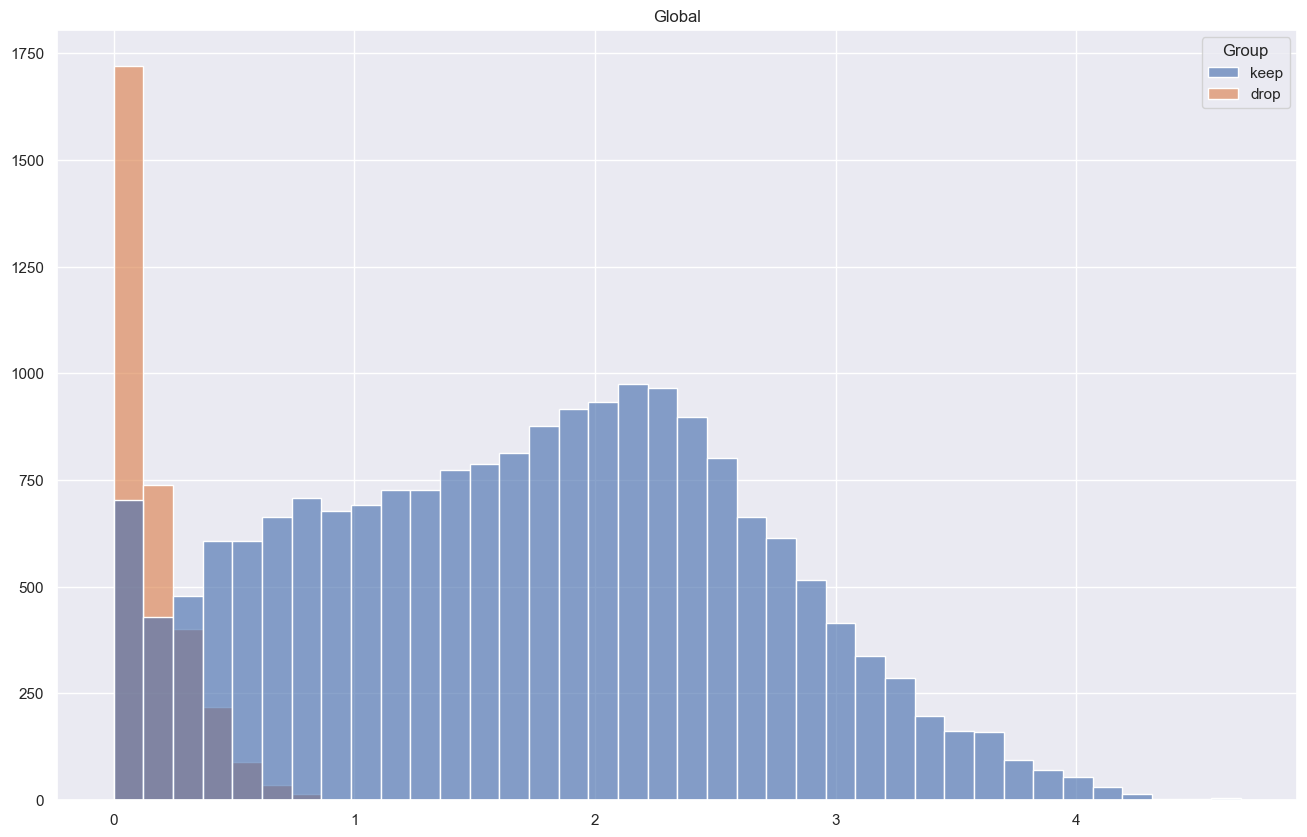

In [16]:
# Display both keep and drop datasets

feature_target.distribution_histplot(
	data     = [distribution_keep, distribution_drop],
	names    = ['keep', 'drop'],
	groupby  = 'global',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-{}-mean'.format('global'))
)

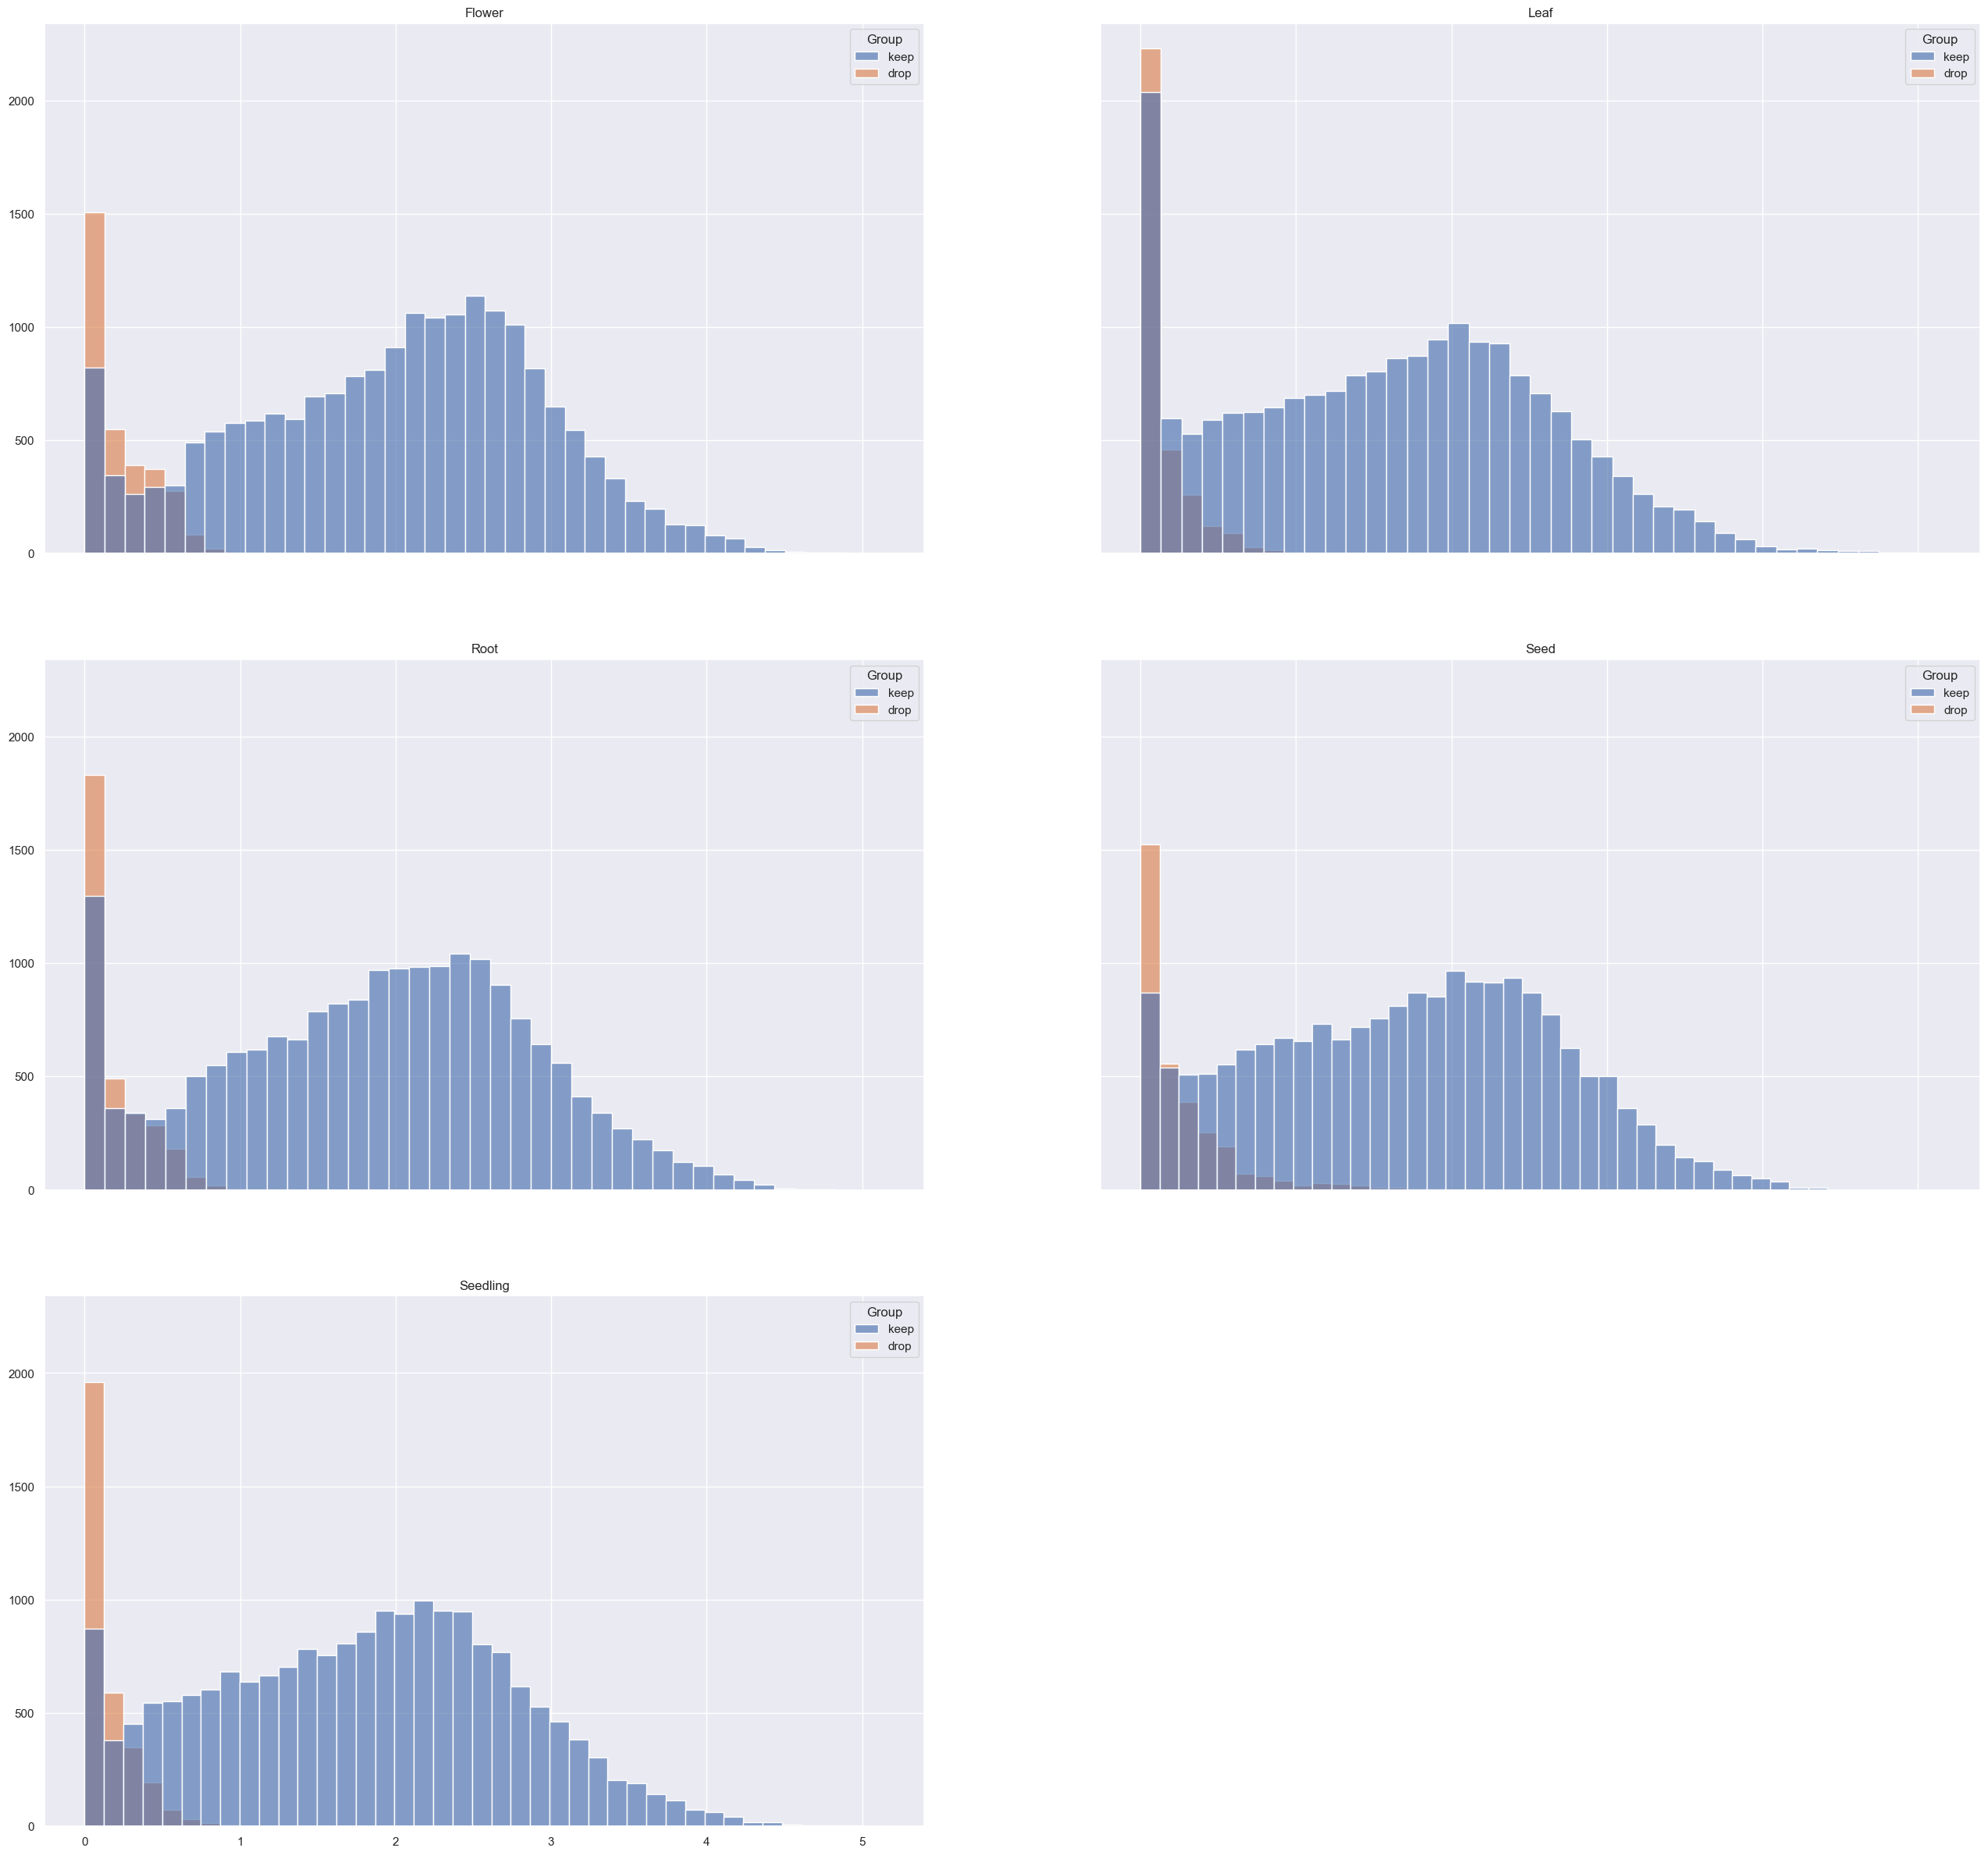

In [17]:
# Display both keep and drop datasets

feature_target.distribution_histplot(
	data     = [distribution_keep, distribution_drop],
	names    = ['keep', 'drop'],
	groupby  = 'tissue',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-{}-mean'.format('tissue'))
)

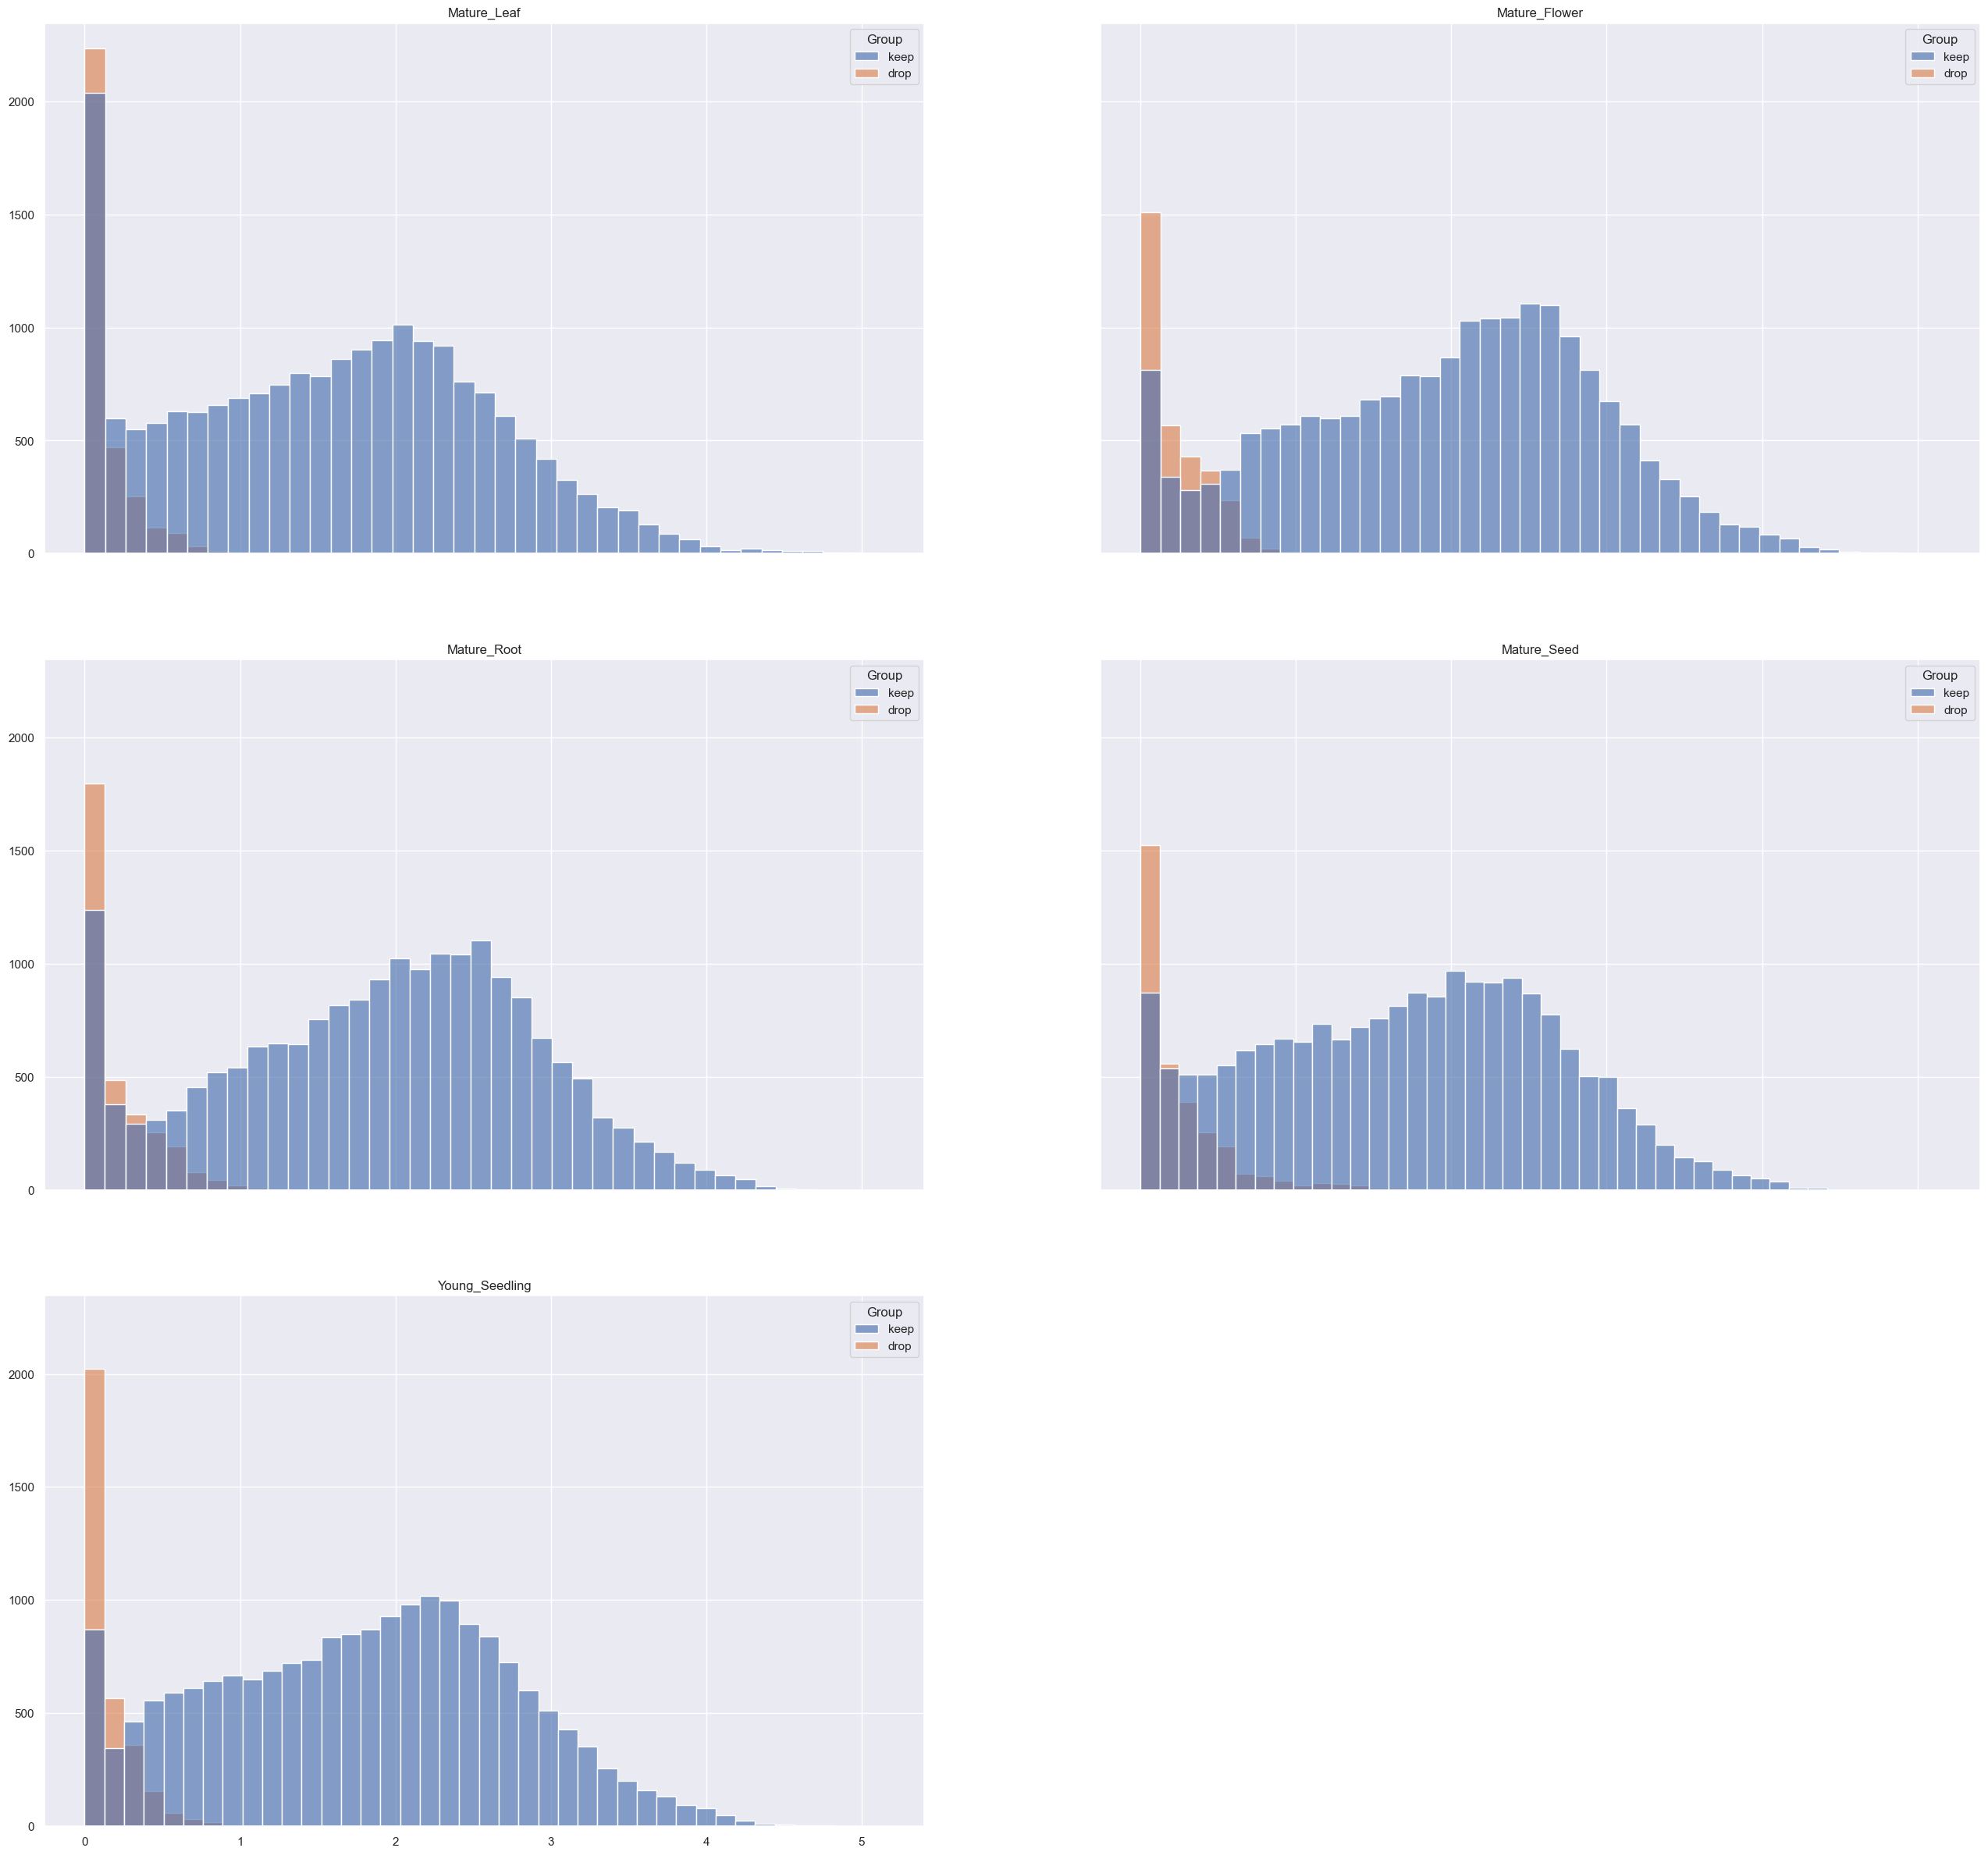

In [18]:
# Display both keep and drop datasets

feature_target.distribution_histplot(
	data     = [distribution_keep, distribution_drop],
	names    = ['keep', 'drop'],
	groupby  = 'group',
	discrete = False,
	filename = os.path.join(OUT_PLOT, 'distribution-{}-mean'.format('group'))
)

## 2.3 Save

In [19]:
# Save the target transcript tpm values

writer.write_json(
	data     = values_keep,
	filename = os.path.join(OUT_DATA, 'target-values-keep.json')
)

writer.write_json(
	data     = values_drop,
	filename = os.path.join(OUT_DATA, 'target-values-drop.json')
)

writer.write_json(
	data     = order,
	filename = os.path.join(OUT_DATA, 'target-order.json')
)

# 3. Classification

## 3.1 Extraction

In [20]:
# Extract the transcript tpm classification per group (reuses tpm values from regression extraction)

labels, bounds = feature_target.classify_tpm(
	data    = values,
	classes = 5
)

In [21]:
# Display bounds in different configurations (start, values and mapping are manually set based on nbp02-anndata)

feature_target.display_bounds_mapping(
	bounds     = bounds['tissue-mean'],
	start      = TARGET_LAYER,
	values = {
		'min_value'  : factor_normal['min'],
		'max_value'  : factor_normal['max'],
		'box_lambda' : factor_boxcox['lambda'],
		'log_base'   : 2
	},
	mapping = mapping_layer
)

                             boxcox1p |                           tpm
---------------------------------------------------------------------
level-0       0.00001 -       0.34410 |       0.00001 -       0.42335
level-1       0.34410 -       1.22721 |       0.42335 -       2.86468
level-2       1.22721 -       1.95818 |       2.86468 -       9.02337
level-3       1.95818 -       2.55623 |       9.02337 -      23.45318
level-4       2.55623 -       5.14392 |      23.45318 -  13,186.87068


In [22]:
# Display an example of the transcript classification

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(labels[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:1d}'.format(x) for x in value))

tissue-max        : [ 5] 2 3 4 2 3
tissue-mean       : [ 5] 2 2 3 2 2
age-max           : [ 4] 3 3 1 3
age-mean          : [ 4] 2 2 2 3
group-max         : [ 5] 3 2 3 3 3
group-mean        : [ 5] 2 2 3 2 2
perturbation-max  : [ 7] 3 3 2 3 3 3 3
perturbation-mean : [ 7] 3 2 3 2 2 2 2
global-mean       : [ 1] 2
global-max        : [ 1] 3


In [23]:
# Split into keep and drop

labels_keep = {k : v for k, v in labels.items() if k in keep_transcript}
labels_drop = {k : v for k, v in labels.items() if k in drop_transcript}

print(' Keep : {:5d}'.format(len(labels_keep)))
print(' Drop : {:5d}'.format(len(labels_drop)))
print('Total : {:5d} / {:5d}'.format(len(labels_drop) + len(labels_keep), len(labels)))

 Keep : 19367
 Drop :  3211
Total : 22578 / 22578


## 3.2 Distribution

In [24]:
# Compute distributions

distribution_keep = feature_target.distribution_group(
	data   = labels_keep,
	order  = order,
	select = 'mean',
	genes  = list(labels_keep.keys())
)

distribution_drop = feature_target.distribution_group(
	data   = labels_drop,
	order  = order,
	select = 'mean',
	genes  = list(labels_drop.keys())
)

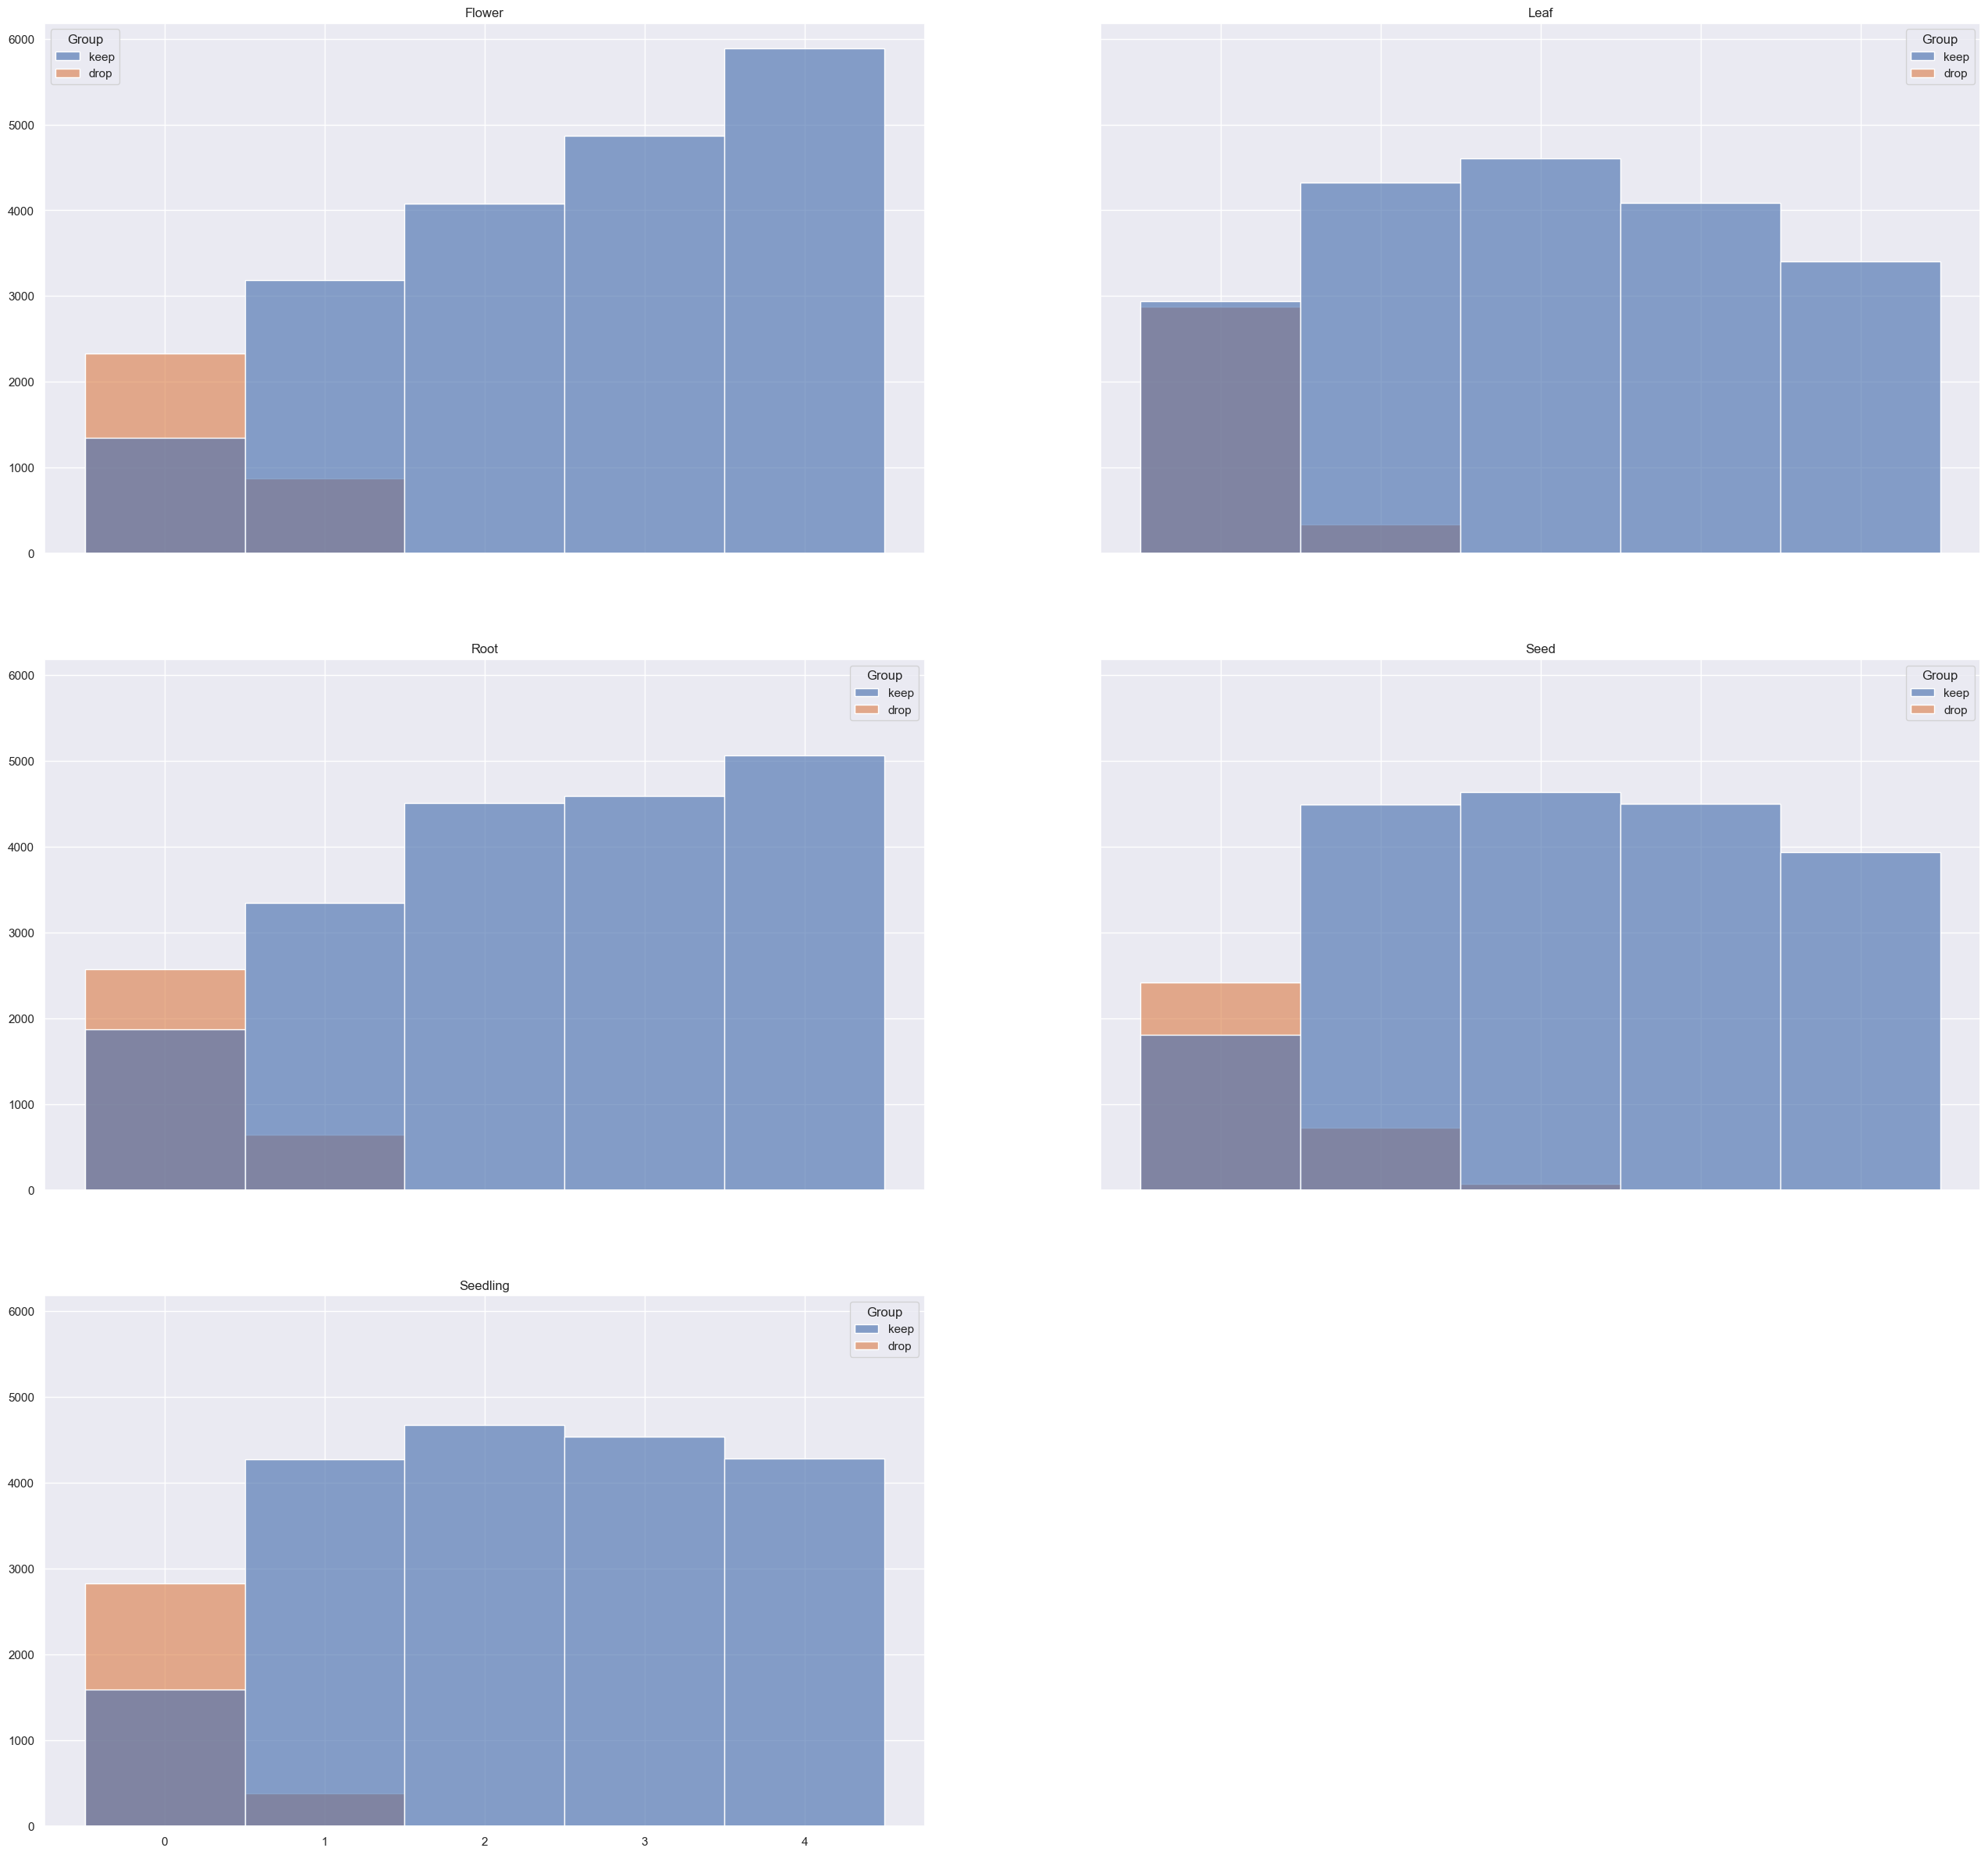

In [25]:
# Display both keep and drop datasets

feature_target.distribution_histplot(
	data     = [distribution_keep, distribution_drop],
	names    = ['keep', 'drop'],
	groupby  = 'tissue',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-{}-mean'.format('tissue'))
)

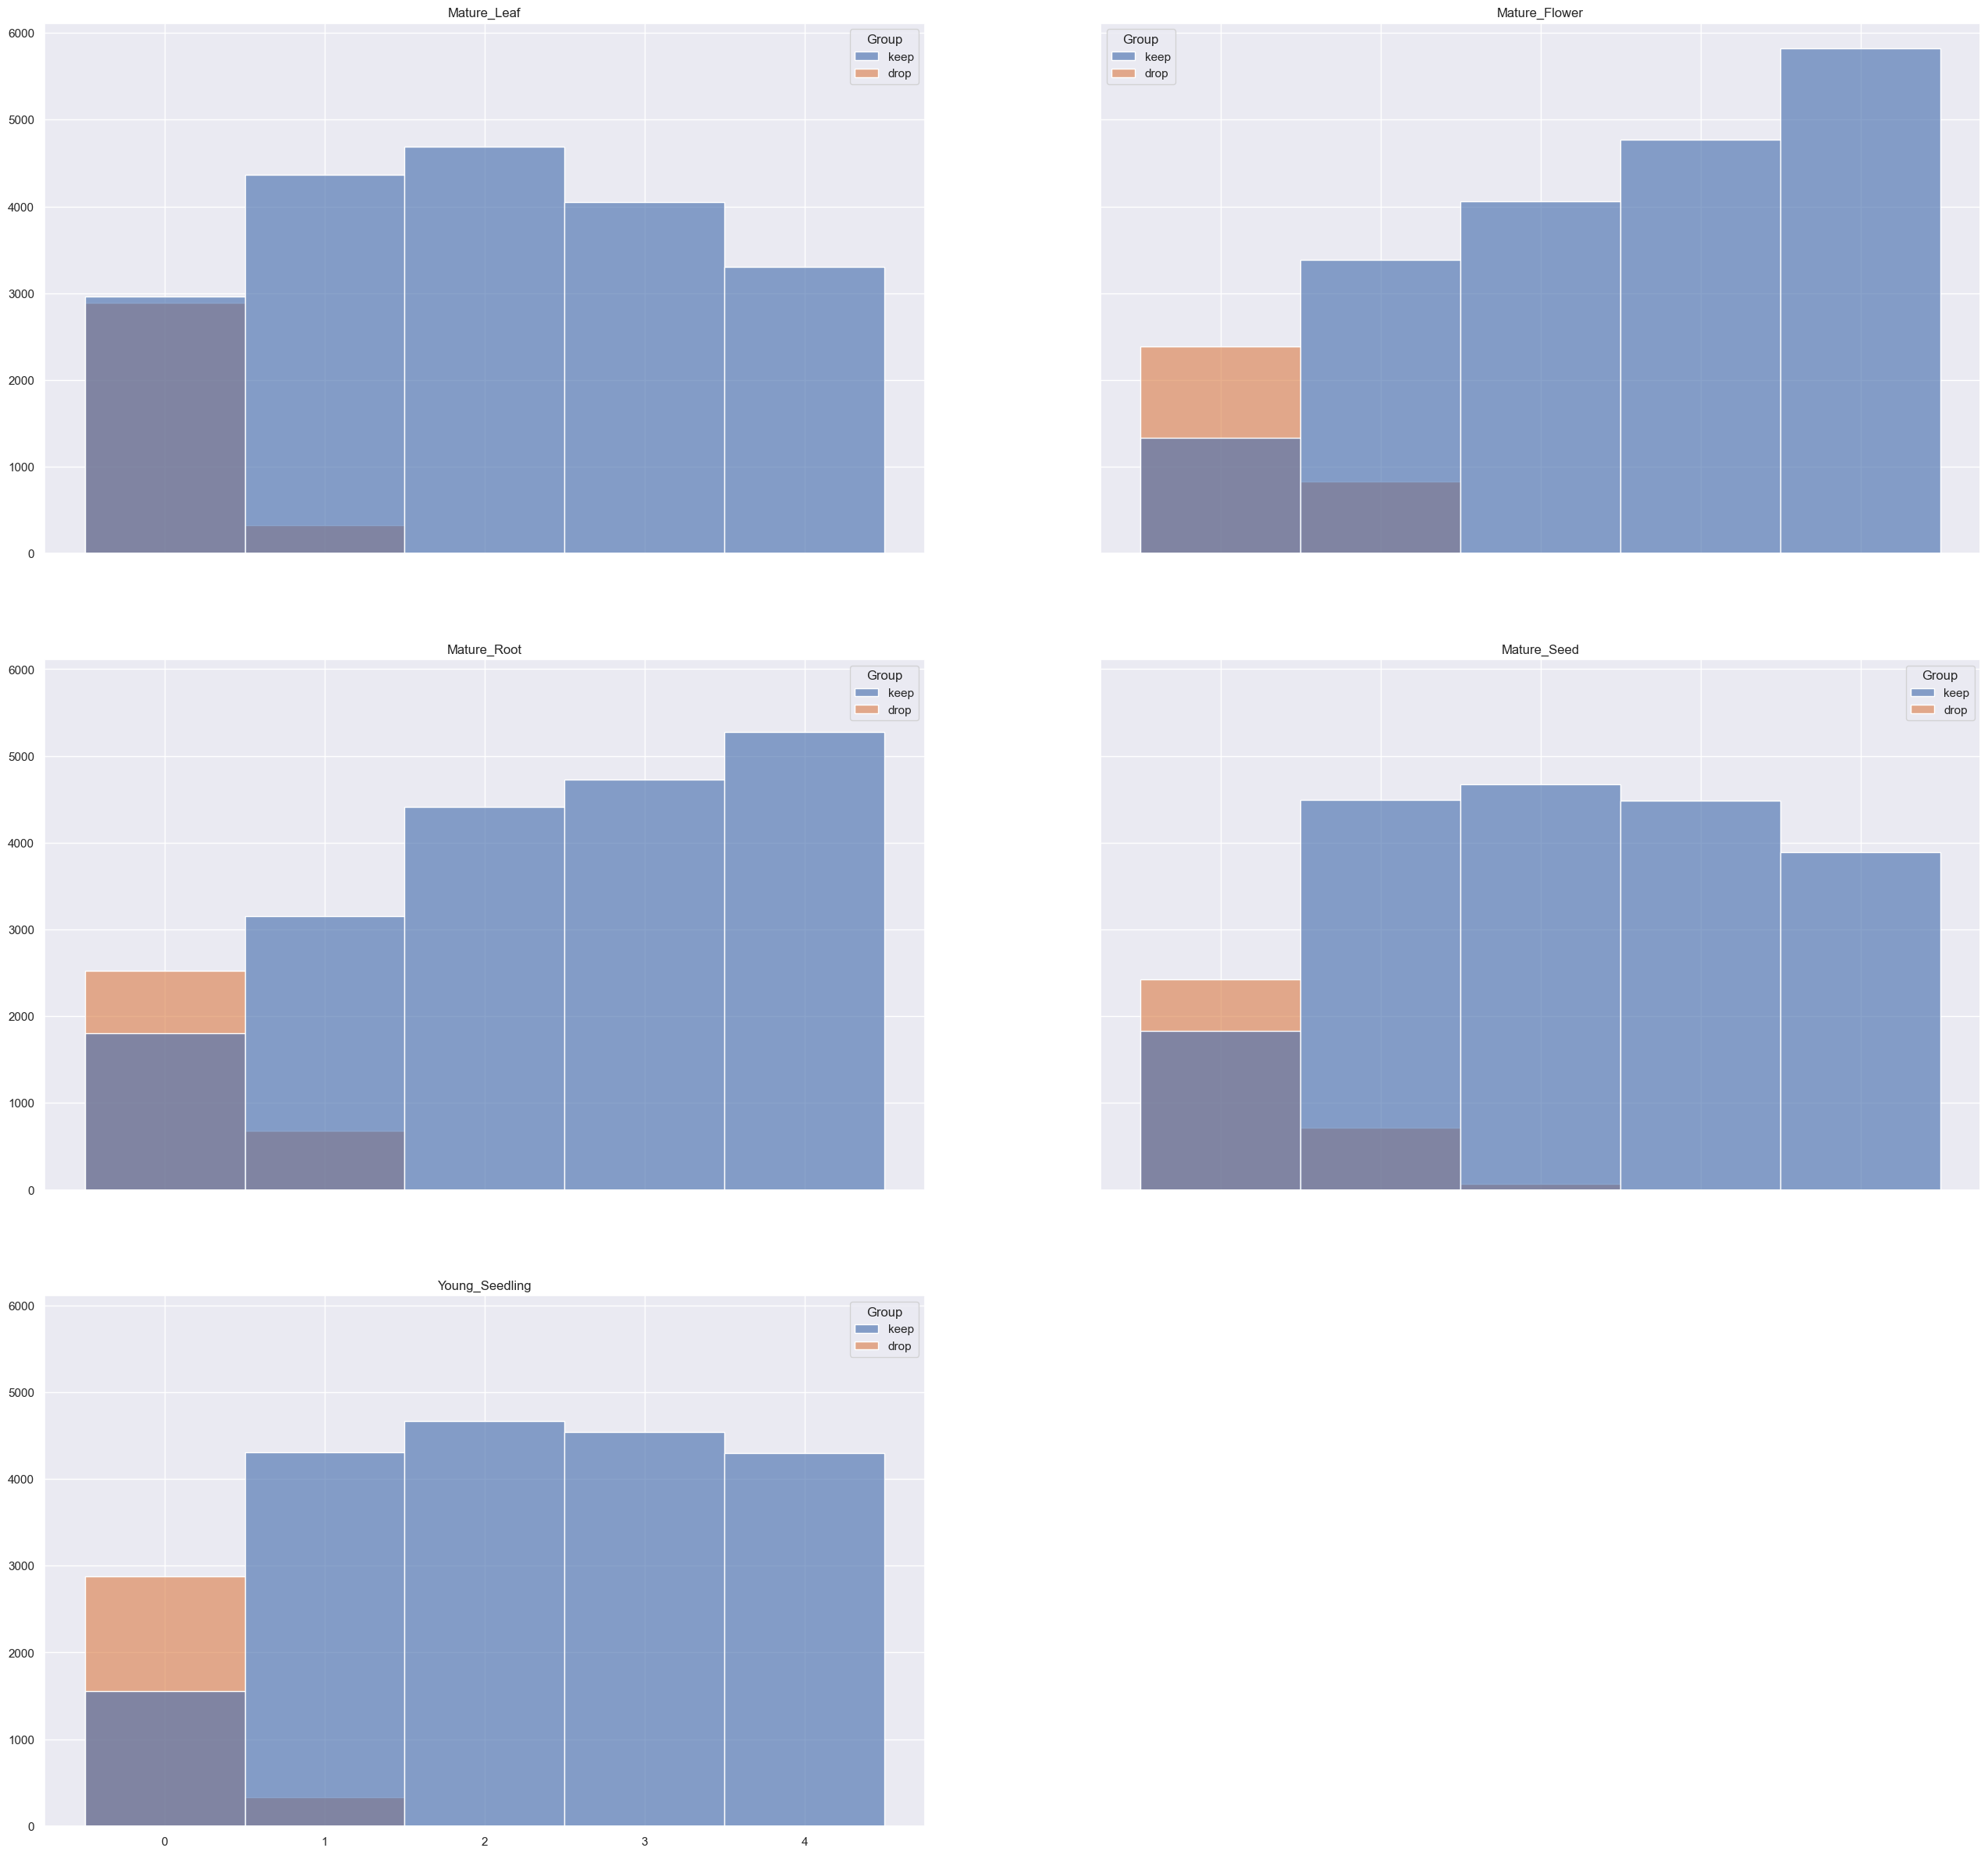

In [26]:
# Display both keep and drop datasets

feature_target.distribution_histplot(
	data     = [distribution_keep, distribution_drop],
	names    = ['keep', 'drop'],
	groupby  = 'group',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-{}-mean'.format('group'))
)

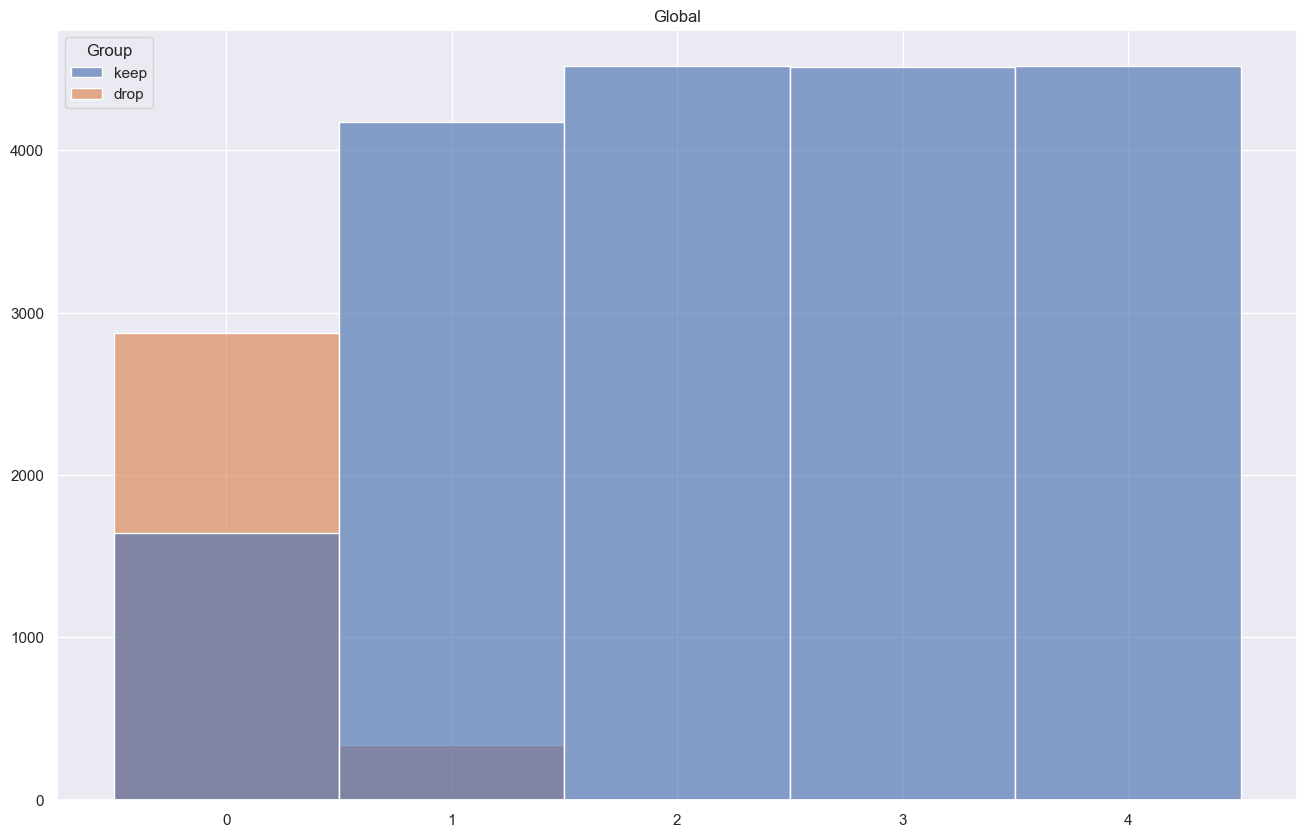

In [27]:
# Display both keep and drop datasets

feature_target.distribution_histplot(
	data     = [distribution_keep, distribution_drop],
	names    = ['keep', 'drop'],
	groupby  = 'global',
	discrete = True,
	filename = os.path.join(OUT_PLOT, 'distribution-{}-mean'.format('global'))
)

## 3.3 Save

In [28]:
# Save the target transcript classification

writer.write_json(
	data     = labels_keep,
	filename = os.path.join(OUT_DATA, 'target-labels-keep.json')
)

writer.write_json(
	data     = labels_drop,
	filename = os.path.join(OUT_DATA, 'target-labels-drop.json')
)

# 4. Mapping

## 4.1 Binarizer

In [29]:
# Create binarizers and mapping lookup

features_binarizer, features_grouped, features_exploded = feature_target.create_mapping(
	values = values,
	labels = labels,
	order  = order
)

In [30]:
# Show keys and labels

for key in features_binarizer.keys() :
	classes = features_binarizer[key].classes_

	if len(classes) > 8 :
		print('{:17s} : {} ...'.format(key, classes[:8]))
	else :
		print('{:17s} : {}'.format(key, classes))

tissue-mean       : ['flower' 'leaf' 'root' 'seed' 'seedling']
tissue-max        : ['flower' 'leaf' 'root' 'seed' 'seedling']
age-mean          : ['mature' 'missing' 'seed' 'young']
age-max           : ['mature' 'missing' 'seed' 'young']
group-mean        : ['mature_flower' 'mature_leaf' 'mature_root' 'mature_seed' 'young_seedling']
group-max         : ['mature_flower' 'mature_leaf' 'mature_root' 'mature_seed' 'young_seedling']
perturbation-mean : ['chemical' 'control' 'dna' 'environmental' 'mechanical' 'mutant' 'unstressed']
perturbation-max  : ['chemical' 'control' 'dna' 'environmental' 'mechanical' 'mutant' 'unstressed']
global-mean       : ['global']
global-max        : ['global']


In [31]:
# Split keep and drop

features_grouped_keep = {
	key : dataframe[dataframe['Transcript'].isin(keep_transcript)].copy()
	for key, dataframe in features_grouped.items()
}

features_exploded_keep = {
	key : dataframe[dataframe['Transcript'].isin(keep_transcript)].copy()
	for key, dataframe in features_exploded.items()
}

features_grouped_drop = {
	key : dataframe[dataframe['Transcript'].isin(drop_transcript)].copy()
	for key, dataframe in features_grouped.items()
}

features_exploded_drop = {
	key : dataframe[dataframe['Transcript'].isin(drop_transcript)].copy()
	for key, dataframe in features_exploded.items()
}

## 4.2 Save

In [32]:
# Save binarizers and mapping lookup

writer.write_pickle(
	data     = features_grouped_keep,
	filename = os.path.join(OUT_DATA, f'mapping-grouped-keep.pkl')
)

writer.write_pickle(
	data     = features_exploded_keep,
	filename = os.path.join(OUT_DATA, f'mapping-exploded-keep.pkl')
)

writer.write_pickle(
	data     = features_grouped_drop,
	filename = os.path.join(OUT_DATA, f'mapping-grouped-drop.pkl')
)

writer.write_pickle(
	data     = features_exploded_drop,
	filename = os.path.join(OUT_DATA, f'mapping-exploded-drop.pkl')
)

# 5. Bert

In [33]:
# Define generated combinations

combinations = [
	('global', 'mean', False, None),
	('tissue', 'mean', True,  None),
	('tissue', 'mean', True, 'seedling'),
	('group',  'mean', True,  None)
]

## 5.1 Transcript - 2150bp

In [34]:
# Constants

size = 2150
name = 'transcript'

In [35]:
# Generate full transcript tokens for bert model

if GENERATE_BERT_TRANSCRIPT_2150 :
	sequences = sequence_2150_keep
	features  = feature_base_keep
	group     = 'keep'

	generator = lambda : bert_data.data_prepare(
		sequences    = sequences,
		features     = features,
		directory    = OUT_DATA,
		valid_split  = 0.0,
		test_split   = 0.2,
		filename     = 'mapping-grouped-{}.pkl'.format(group),
		combinations = combinations
	)

	for data, filename in generator() :
		bert_data.create_kmers(
			filename     = os.path.join(OUT_DATA, 'dnabert-{}', '{}-{}'.format(name, size), '{}'.format(filename), '{}' + '-{}.tsv'.format(group)),
			generator    = dataset_split.generate_group_shuffle_split,
			max_tokens   = None,
			random_seed  = RANDOM_SEED,
			data         = data
		)

In [36]:
# Generate full transcript tokens for bert model

if GENERATE_BERT_TRANSCRIPT_2150 :
	sequences = sequence_2150_drop
	features  = feature_base_drop
	group     = 'drop'

	generator = lambda : bert_data.data_prepare(
		sequences    = sequences,
		features     = features,
		directory    = OUT_DATA,
		valid_split  = 0.0,
		test_split   = 0.2,
		filename     = 'mapping-grouped-{}.pkl'.format(group),
		combinations = combinations
	)

	for data, filename in generator() :
		bert_data.create_kmers(
			filename     = os.path.join(OUT_DATA, 'dnabert-{}', '{}-{}'.format(name, size), '{}'.format(filename), '{}' + '-{}.tsv'.format(group)),
			generator    = dataset_split.generate_group_shuffle_split,
			max_tokens   = None,
			random_seed  = RANDOM_SEED,
			data         = data
		)

## 5.2 Promoter - 512bp

In [37]:
# Constants

size = 512
name = 'promoter'

In [38]:
# Generate 512 promoter tokens for bert model

if GENERATE_BERT_PROMOTER_512 :
	sequences = sequence_prom_keep
	features  = feature_base_keep
	group     = 'keep'

	generator = lambda : bert_data.data_prepare(
		sequences    = sequences,
		features     = features,
		directory    = OUT_DATA,
		valid_split  = 0.0,
		test_split   = 0.2,
		filename     = 'mapping-grouped-{}.pkl'.format(group),
		combinations = combinations
	)

	for data, filename in generator() :
		bert_data.create_kmers(
			filename     = os.path.join(OUT_DATA, 'dnabert-{}', '{}-{}'.format(name, size), '{}'.format(filename), '{}' + '-{}.tsv'.format(group)),
			generator    = dataset_split.generate_group_shuffle_split,
			max_tokens   = -size,
			random_seed  = RANDOM_SEED,
			data         = data
		)

In [39]:
# Generate 512 promoter tokens for bert model

if GENERATE_BERT_PROMOTER_512 :
	sequences = sequence_prom_drop
	features  = feature_base_drop
	group     = 'drop'

	generator = lambda : bert_data.data_prepare(
		sequences    = sequences,
		features     = features,
		directory    = OUT_DATA,
		valid_split  = 0.0,
		test_split   = 0.2,
		filename     = 'mapping-grouped-{}.pkl'.format(group),
		combinations = combinations
	)

	for data, filename in generator() :
		bert_data.create_kmers(
			filename     = os.path.join(OUT_DATA, 'dnabert-{}', '{}-{}'.format(name, size), '{}'.format(filename), '{}' + '-{}.tsv'.format(group)),
			generator    = dataset_split.generate_group_shuffle_split,
			max_tokens   = -size,
			random_seed  = RANDOM_SEED,
			data         = data
		)

## 5.3 Promoter - 4096bp

In [40]:
# Constants

size = 4096
name = 'promoter'

In [41]:
# Generate 4096 promoter tokens for bert model

if GENERATE_BERT_PROMOTER_4096 :
	sequences = sequence_prom_keep
	features  = feature_base_keep
	group     = 'keep'

	generator = lambda : bert_data.data_prepare(
		sequences    = sequences,
		features     = features,
		directory    = OUT_DATA,
		valid_split  = 0.0,
		test_split   = 0.2,
		filename     = 'mapping-grouped-{}.pkl'.format(group),
		combinations = combinations
	)

	for data, filename in generator() :
		bert_data.create_kmers(
			filename     = os.path.join(OUT_DATA, 'dnabert-{}', '{}-{}'.format(name, size), '{}'.format(filename), '{}' + '-{}.tsv'.format(group)),
			generator    = dataset_split.generate_group_shuffle_split,
			max_tokens   = -size,
			random_seed  = RANDOM_SEED,
			data         = data
		)

In [42]:
# Generate 4096 promoter tokens for bert model

if GENERATE_BERT_PROMOTER_4096 :
	sequences = sequence_prom_drop
	features  = feature_base_drop
	group     = 'drop'

	generator = lambda : bert_data.data_prepare(
		sequences    = sequences,
		features     = features,
		directory    = OUT_DATA,
		valid_split  = 0.0,
		test_split   = 0.2,
		filename     = 'mapping-grouped-{}.pkl'.format(group),
		combinations = combinations
	)

	for data, filename in generator() :
		bert_data.create_kmers(
			filename     = os.path.join(OUT_DATA, 'dnabert-{}', '{}-{}'.format(name, size), '{}'.format(filename), '{}' + '-{}.tsv'.format(group)),
			generator    = dataset_split.generate_group_shuffle_split,
			max_tokens   = -size,
			random_seed  = RANDOM_SEED,
			data         = data
		)

## 5.4 Promoter - 4096bp (with UTR5)

In [43]:
# Constants

size = 4096
name = 'promoter-utr5'

In [44]:
# Generate 4096 promoter tokens for bert model

if GENERATE_BERT_PROMOTER_UTR5_4096 :
	sequences = sequence_prom_utr5_keep
	features  = feature_base_keep
	group     = 'keep'

	generator = lambda : bert_data.data_prepare(
		sequences    = sequences,
		features     = features,
		directory    = OUT_DATA,
		valid_split  = 0.0,
		test_split   = 0.2,
		filename     = 'mapping-grouped-{}.pkl'.format(group),
		combinations = combinations
	)

	for data, filename in generator() :
		bert_data.create_kmers(
			filename     = os.path.join(OUT_DATA, 'dnabert-{}', '{}-{}'.format(name, size), '{}'.format(filename), '{}' + '-{}.tsv'.format(group)),
			generator    = dataset_split.generate_group_shuffle_split,
			max_tokens   = -size,
			random_seed  = RANDOM_SEED,
			data         = data
		)

In [45]:
if GENERATE_BERT_PROMOTER_UTR5_4096 :
	sequences = sequence_prom_utr5_drop
	features  = feature_base_drop
	group     = 'drop'

	generator = lambda : bert_data.data_prepare(
		sequences    = sequences,
		features     = features,
		directory    = OUT_DATA,
		valid_split  = 0.0,
		test_split   = 0.2,
		filename     = 'mapping-grouped-{}.pkl'.format(group),
		combinations = combinations
	)

	for data, filename in generator() :
		bert_data.create_kmers(
			filename     = os.path.join(OUT_DATA, 'dnabert-{}', '{}-{}'.format(name, size), '{}'.format(filename), '{}' + '-{}.tsv'.format(group)),
			generator    = dataset_split.generate_group_shuffle_split,
			max_tokens   = -size,
			random_seed  = RANDOM_SEED,
			data         = data
		)